In [1]:
from datetime import datetime
from glob import glob
import os

from keras import Input, Model
from keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten
from matplotlib import pyplot as plt
from numpy import interp
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
import tensorflow.keras as k
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.ops.confusion_matrix import confusion_matrix

In [2]:
DEBUG = 1
SAVE = 0

BATCH = 256
EPOCH = 256
ES = 128

MIN, MAX = 0, 255
CLASS = [0, 1]

## FUNCTIONS

In [3]:
def log(l):
  if DEBUG == 1: print(l)


def draw_CM(label, predicted):
  cm = confusion_matrix(label, predicted)
  sns.heatmap(cm, annot=True, fmt="d")
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  # true : false rate
  true = 0
  false = 0
  for i, j in enumerate(label):
    if j != predicted[i]:
      false += 1
    else: true += 1
  classification_report = metrics.classification_report(label, predicted)
  multilabel_to_binary_matrics = metrics.multilabel_confusion_matrix(label, predicted)

  return plt.show(), print('true rate: ', true), print('false rate: ', false), print(), print('='*10,
                                                                                              'classification_report: ',
                                                                                              '\n',
                                                                                              classification_report), print(
    '='*10, 'multilabel_to_binary_matrics by class_num: ', '\n', '[[TN / FP] [FN / TP]]',
    '\n', multilabel_to_binary_matrics)


def draw_ROC_AUC(x, y, category_names):
  n_classes = len(category_names)

  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y[:, i], x[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

  fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y.ravel(), x.ravel())
  roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

  plt.figure()
  plt.plot(fpr["micro"], tpr["micro"],
           label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
           color='deeppink', linestyle=':', linewidth=1)

  plt.plot(fpr["macro"], tpr["macro"],
           label=f'macro-average ROC curve (area = {roc_auc["macro"]:0.2f})',
           color='navy', linestyle=':', linewidth=1)

  colors = (['purple', 'pink', 'red', 'green', 'yellow', 'cyan', 'magenta', 'blue'])
  for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1, label=f'Class {i} ROC curve (area = {roc_auc[i]:0.2f})')

  plt.plot([0, 1], [0, 1], 'k--', lw=1)
  plt.xlim([-.01, 1.0])
  plt.ylim([0.0, 1.01])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC & AUC')
  plt.legend(loc="lower right")

  return plt.show()


## DATASET

In [4]:
base_dir = "out"
img_list = glob(f"{base_dir}/*.png")
df = pd.read_csv(f"{base_dir}/output(err_dropped).csv")
log(df.head)

col = list(df.columns)
log(col)

<bound method NDFrame.head of                      img  cnt
0      1650315736806.png    0
1      1650315796123.png    0
2      1650315856514.png    0
3      1650315917006.png    0
4      1650315976418.png    0
...                  ...  ...
27285  1652664376966.png    0
27286  1652664436118.png    0
27287  1652664496517.png    0
27288  1652664556896.png    2
27289  1652664616301.png    0

[27290 rows x 2 columns]>
['img', 'cnt']


## PRE-PROCESS

In [5]:
## PATH TO REAL_PATH
for i in range(len(df)):
  df.iloc[i, 0] = f"{base_dir}/{df.iloc[i, 0]}"

## GET H,W
sample_img = Image.open(df.iloc[16, 0])
img_array = np.array(sample_img, int)
H, W = img_array.shape

## DATASET TO TENSOR
data = []
label = []
for index, row in df.iterrows():
  img = Image.open(row[col[0]])
  img = data.append(list(img.getdata()))
  lbl = label.append(row[col[1]])
  if index % 1000 == 0:  log(index)

data = np.array(data)
data = data.reshape(data.shape[0], H, W, 1)

label = np.array(label)
label = label.reshape(label.shape[0], 1)

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800
6000
6200
6400
6600
6800
7000
7200
7400
7600
7800
8000
8200
8400
8600
8800
9000
9200
9400
9600
9800
10000
10200
10400
10600
10800
11000
11200
11400
11600
11800
12000
12200
12400
12600
12800
13000
13200
13400
13600
13800
14000
14200
14400
14600
14800
15000
15200
15400
15600
15800
16000
16200
16400
16600
16800
17000
17200
17400
17600
17800
18000
18200
18400
18600
18800
19000
19200
19400
19600
19800
20000
20200
20400
20600
20800
21000
21200
21400
21600
21800
22000
22200
22400
22600
22800
23000
23200
23400
23600
23800
24000
24200
24400
24600
24800
25000
25200
25400
25600
25800
26000
26200
26400
26600
26800
27000
27200


In [6]:
## Nomalize
log(data[100:103])
norm_data = data/MAX
log(norm_data[100:103])

## Split
split = int(len(label)*0.9)
train_data, test_data = norm_data[:split], norm_data[split:]
train_label, test_label = label[:split], label[split:]


[[[[ 0]
   [ 0]
   [ 0]
   ...
   [ 0]
   [ 0]
   [ 0]]

  [[ 0]
   [ 0]
   [ 0]
   ...
   [ 0]
   [ 0]
   [ 0]]

  [[ 0]
   [ 0]
   [ 0]
   ...
   [ 0]
   [ 0]
   [ 0]]

  ...

  [[ 0]
   [ 0]
   [ 0]
   ...
   [ 0]
   [ 0]
   [ 0]]

  [[ 0]
   [ 0]
   [ 0]
   ...
   [ 0]
   [ 0]
   [ 0]]

  [[ 0]
   [ 0]
   [ 0]
   ...
   [ 0]
   [ 0]
   [ 0]]]


 [[[ 0]
   [ 0]
   [ 0]
   ...
   [ 0]
   [ 0]
   [ 0]]

  [[ 0]
   [ 0]
   [ 0]
   ...
   [ 0]
   [ 0]
   [ 0]]

  [[ 0]
   [ 0]
   [ 0]
   ...
   [ 0]
   [ 0]
   [ 0]]

  ...

  [[ 0]
   [ 0]
   [ 0]
   ...
   [ 0]
   [ 0]
   [ 0]]

  [[ 0]
   [ 0]
   [ 0]
   ...
   [ 0]
   [ 0]
   [ 0]]

  [[ 0]
   [ 0]
   [ 0]
   ...
   [ 0]
   [ 0]
   [ 0]]]


 [[[ 0]
   [ 0]
   [ 0]
   ...
   [ 0]
   [ 0]
   [ 0]]

  [[ 0]
   [ 0]
   [ 0]
   ...
   [ 0]
   [ 0]
   [ 0]]

  [[ 0]
   [ 0]
   [ 0]
   ...
   [ 0]
   [ 0]
   [ 0]]

  ...

  [[ 0]
   [12]
   [ 0]
   ...
   [ 0]
   [ 0]
   [ 0]]

  [[17]
   [41]
   [25]
   ...
   [ 0]
   [ 0]
   [ 0]]

  [[12

## MODEL

In [7]:
input = Input(shape=(H, W, 1))

x = Conv2D(128, (3, 3))(input)
x = BatchNormalization()(x)
x = Activation('selu')(x)
x = Dropout(.1)(x)

x = Conv2D(64, (3, 3))(x)
x = BatchNormalization()(x)
x = Activation('selu')(x)
x = Dropout(.1)(x)

x = Conv2D(32, (3, 3))(x)
x = BatchNormalization()(x)
x = Activation('selu')(x)
x = Dropout(.1)(x)

x = Flatten()(x)

x = Dense(256, activation="selu")(x)
x = Dense(128, activation="selu")(x)
x = Dense(64, activation="selu")(x)

output = Dense(24, activation="softmax")(x)

model = Model(input, output)

2022-06-27 23:36:59.812943: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-27 23:36:59.816985: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-27 23:36:59.817268: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-27 23:36:59.818272: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## TRAIN

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 58, 46, 128)       1280      
                                                                 
 batch_normalization (BatchN  (None, 58, 46, 128)      512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 58, 46, 128)       0         
                                                                 
 dropout (Dropout)           (None, 58, 46, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 44, 64)        73792     
                                                             

2022-06-27 23:37:01.799750: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-06-27 23:37:02.759387: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-06-27 23:37:02.936323: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.72GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-06-27 23:37:02.936361: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.72GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-06-27 23:37:03.071256: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplicat

87/87 [==============================] - 10s 84ms/step - loss: 2.2577 - accuracy: 0.5499 - val_loss: 5.8572 - val_accuracy: 0.4717
Epoch 2/256
87/87 [==============================] - 7s 77ms/step - loss: 0.9017 - accuracy: 0.6591 - val_loss: 6.6777 - val_accuracy: 0.4717
Epoch 3/256
87/87 [==============================] - 7s 78ms/step - loss: 0.6440 - accuracy: 0.7525 - val_loss: 5.3876 - val_accuracy: 0.4717
Epoch 4/256
87/87 [==============================] - 7s 78ms/step - loss: 0.4592 - accuracy: 0.8299 - val_loss: 3.1157 - val_accuracy: 0.4811
Epoch 5/256
87/87 [==============================] - 7s 76ms/step - loss: 0.2804 - accuracy: 0.9037 - val_loss: 2.5293 - val_accuracy: 0.5144
Epoch 6/256
87/87 [==============================] - 7s 79ms/step - loss: 0.1512 - accuracy: 0.9545 - val_loss: 2.0530 - val_accuracy: 0.5283
Epoch 7/256
87/87 [==============================] - 7s 77ms/step - loss: 0.0799 - accuracy: 0.9800 - val_loss: 2.5575 - val_accuracy: 0.5564
Epoch 8/256
87/87

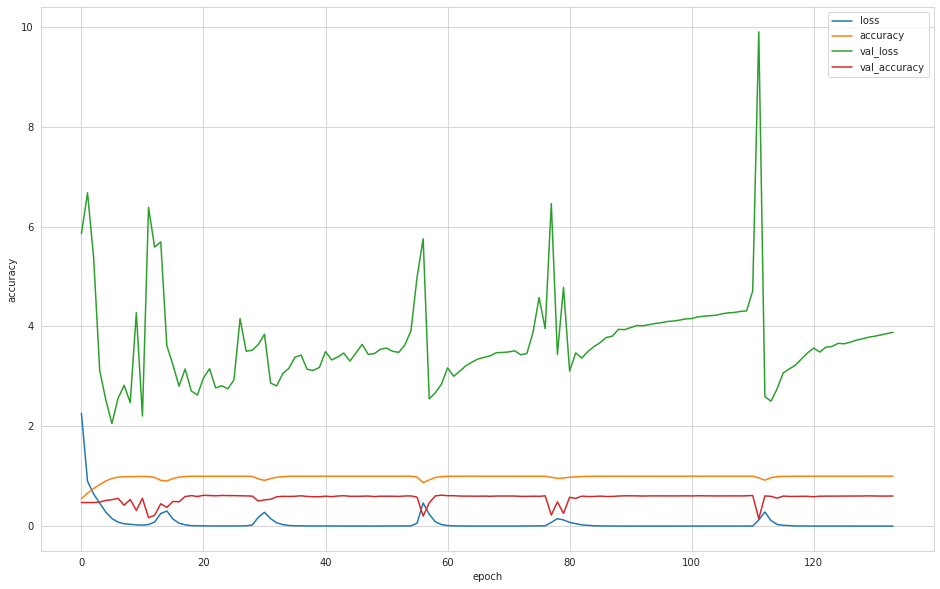

In [8]:
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

## fit
log_path = "logs/"+datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = k.callbacks.TensorBoard(log_dir=log_path, histogram_freq=1)
es = EarlyStopping(monitor="val_loss", patience=ES, mode="auto", verbose=2)

history = model.fit(train_data, train_label, validation_split=0.1, batch_size=BATCH, epochs=EPOCH, verbose=1,
                    callbacks=[es])  # callbacks=[es, tensorboard_callback])
print(history)

## plot
pd.DataFrame(history.history).plot(figsize=(16, 10), grid=1, xlabel="epoch", ylabel="accuracy")
plt.show()


## EVALUATE

In [9]:
loss, acc = model.evaluate(test_data, test_label, verbose=1)

predict = model.predict(test_data)
predicted = np.argmax(predict, axis=1)


86/86 [==============================] - 0s 3ms/step


/home/z/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/z/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/z/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


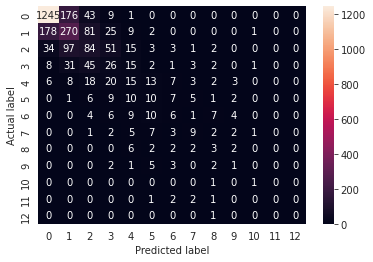

true rate:  1670
false rate:  1059

========== classification_report:  
               precision    recall  f1-score   support

           0       0.85      0.84      0.85      1474
           1       0.46      0.48      0.47       566
           2       0.30      0.29      0.29       290
           3       0.17      0.19      0.18       134
           4       0.17      0.16      0.17        95
           5       0.18      0.20      0.19        51
           6       0.18      0.13      0.15        47
           7       0.35      0.28      0.31        32
           8       0.12      0.18      0.15        17
           9       0.07      0.07      0.07        14
          10       0.25      0.50      0.33         2
          11       0.00      0.00      0.00         6
          12       0.00      0.00      0.00         1

    accuracy                           0.61      2729
   macro avg       0.24      0.26      0.24      2729
weighted avg       0.61      0.61      0.61      2729

======

NameError: name 'label_binarize' is not defined

In [10]:
## CM
draw_CM(test_label, predicted)

## ROC, AUC
x = label_binarize(predicted, classes=classes)
y = label_binarize(y_test, classes=classes)
draw_ROC_AUC(x, y, CLASS)

In [ ]:
if SAVE == 1:
  file_name = "model/light_detector_"+dt.now().strftime("%Y%m%d-%H%M%S")
  model_format = ".h5"
  model_name = file_name+model_format
  model.save(model_name)
